<a href="https://colab.research.google.com/github/cardstdani/practica-par/blob/main/PracticaParadigmas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Práctica Paradigmas 1**

In [ ]:
!pip install pyvis==0.3.1

In [ ]:
import random
import math
import copy
import pandas as pd
import numpy as np
from IPython.display import display, HTML
import matplotlib.pyplot as plt

class TrieNode:
    def __init__(self, inputChar):
        self.char = inputChar
        self.end = False
        self.children = {}
 
class Trie():
    def __init__(self, startingElements=None):
        self.root = TrieNode("")
        if startingElements!=None:
          for i in startingElements: self.insert(i)
    def insert(self, word):
        node = self.root
        for char in word:
            if char in node.children:
                node = node.children[char]
            else:
                new_node = TrieNode(char)
                node.children[char] = new_node
                node = new_node
        node.end = True      
    def searchAndSplit(self, x):
        node = self.root
        output = ["", ""]
        for char in x:
            if char in node.children:
                node = node.children[char]            
            else:
                return []        
            output[1 if node.end else 0] += node.char
        return output if node.end else []
    def toGraph(self):
      from pyvis.network import Network
      g = Network(directed =True)      
      g.show_buttons()

      nodeIndex = 1
      currentNode = 0
      q = [self.root]      
      g.add_node(currentNode, label="", color="red")
      tempLabels = {0:""}
      while q!=[]:
        n = q.pop(0)                     
        for i in n.children.values():
          tempLabels[nodeIndex] = tempLabels[currentNode]+i.char
          g.add_node(nodeIndex, label=tempLabels[currentNode]+i.char, color="#48e073" if i.end else "blue")
          g.add_edge(currentNode, nodeIndex)
          nodeIndex+=1
          q.append(i)
        currentNode+=1
      g.show('nx.html')

class MainGame:
  def __init__(self):
    #random.seed(368) #311
    self.objects = {".":[".",0],"a":["b",1],"b":["c",5],"c":["d",25],"d":["e",125],"e":["e",625],"1":["1",-25],"2":["3",-5],"3":["4",50],"4":["4",500],"x":["x",-50]}
    self.checkAndLoadFiles()    
    self.turn = 0
    self.score = []
    self.storage = "."
    self.bigFoots = [[(i,j), 0, False] for i in range(len(self.matrix)) for j in range(len(self.matrix[0])) if self.matrix[i][j]=="1"]
    self.updateActual()
    self.tr = Trie((''.join(chr(97+int(j)) for j in str(i))+str(k) for k in range(len(self.matrix[0])) for i in range(len(self.matrix))))
    self.tr.insert("exit")
    self.tr.insert("hint")
    self.tr.insert("*")
    self.tr.toGraph()

  def checkAndLoadFiles(self):
    try:
      with open("tablero.txt", "r") as f:
        self.matrix=[]        
        for i in f.readlines():
          self.matrix.append([])
          for j in i.replace("\n", ""):
            if not j in self.objects: raise
            self.matrix[-1].append(j)
    except:
      self.matrix = [random.sample(["."]*45+["a"]*18+["b"]*4+["c"]*3+["1"]*2, 10) for i in range(10)]
      print("Error al cargar el fichero tablero, usando tablero aleatorio...")      
    try:
      with open("secuencia.txt", "r") as f:
        self.seq=""
        for i in f.readline():
          if i not in self.objects and i != "w": raise
          self.seq += i
    except:
      self.seq = ""
      print("Error al cargar el fichero secuencia, usando secuencia aleatoria...")      

  def main(self):
    print("Que empiece el juego:\U0001F609")
    self.showGame()    
    while any("." in x for x in self.matrix):
      message = self.validarEntrada(input("Mover a casilla: ").lower().replace(" ", ""))
      while not message[0]: message = self.validarEntrada(input("Jugada errónea\nMover a casilla: ").lower().replace(" ", ""))

      if "".join(message[1])=="exit": break
      if "".join(message[1])=="*": self.storage=self.actual; self.updateActual(); self.showGame(); continue;
      coordinates = (lambda l: (int("".join([str(ord(i)%97) for i in l[0]])), int(l[1])))(message[1]) if "".join(message[1])!="hint" else self.getHint()
      if not ((self.matrix[coordinates[0]][coordinates[1]]==".") ^ (self.actual=="w")): print("Jugada errónea"); continue;

      self.updateMatrix(coordinates)
      self.updateActual()
      self.turn+=1
      self.bigFoots = [[i[0], i[1]+1, i[2]] for i in self.bigFoots]
      
      self.showGame()
    print("Partida terminada, GG:\U0001F44F")
    self.plotScore()

  def getHint(self):
    prevObjs = sum(1 - self.objects[b][1] for a in self.matrix for b in a if b!=".")
    tempValues=[-math.inf, (0,0)]
    #debugValues = [[0]*len(self.matrix[0]) for i in range(len(self.matrix))]
    for i in range(len(self.matrix)):
      for j in range(len(self.matrix[0])):
        if (self.matrix[i][j] == ".") ^ (self.actual=="w"): 
          newObj = copy.deepcopy(g)
          newObj.updateMatrix((i,j))
          newScore = sum(sum(self.objects[b][1] - (b != "." or 0) for b in a) for a in newObj.matrix) + prevObjs - 12*newObj.minDistanceToElement((i,j), ["1", "2", newObj.matrix[i][j]])
          if newScore>tempValues[0]: tempValues = [newScore, (i,j)]
          #debugValues[i][j] = newScore
    #plt.imshow(debugValues, cmap='hot', interpolation='nearest')
    #plt.show()
    return tempValues[1]
  
  def plotScore(self):
    x = np.array(list(range(len(self.score))))
    m,c = self.linReg(x, self.score)
    fig = plt.figure(figsize=(12, 12))
    plt.plot(x, self.score)
    plt.plot(x, m*x + c)
    plt.show()
  
  def linReg(self, x, y):
    return np.linalg.lstsq(np.vstack([x, np.ones(len(x))]).T, y)[0]

  def minDistanceToElement(self, coordinates, elements):
    visited = set()
    q = [(coordinates, 0)]
    while q:
        n, distance = q.pop(0)
        if n in visited:
            continue
        visited.add(n)
        for i, j in ((n[0]-1, n[1]), (n[0]+1, n[1]), (n[0], n[1]-1), (n[0], n[1]+1)):
            if i < 0 or i >= len(self.matrix) or j < 0 or j >= len(self.matrix[0]): continue
            if self.matrix[i][j] in elements: return distance+1
            q.append(((i,j), distance+1))
    return 0   
  
  def updateActual(self):
    self.actual = random.choice(["a"]*30+["b"]*5+["c"]*1+["1"]*6+["w"]*1) if self.seq=="" else self.seq[self.turn%len(self.seq)]
  
  def updateMatrix(self, coordinates):
    if self.actual=="w": self.matrix[coordinates[0]][coordinates[1]] = "."; self.deleteBigFoot(coordinates); return;
    self.matrix[coordinates[0]][coordinates[1]] = self.actual
    if self.actual=="1": self.bigFoots.append([coordinates, 0, False]); self.updateBigFoots(); return;

    self.checkAndColapse(coordinates)
    self.updateBigFoots()

  def checkAndColapse(self, coordinates):
    g = (self.getGroup(coordinates), self.matrix[coordinates[0]][coordinates[1]])
    if g[1]=="2": coordinates = max(g[0], key=lambda x:[k for k in self.bigFoots if k[0]==x][0][1])
    while len(g[0])>2:
      for i in g[0]: 
        if self.matrix[i[0]][i[1]] == "2": self.deleteBigFoot(i);
        self.matrix[i[0]][i[1]] = "."
      self.matrix[coordinates[0]][coordinates[1]] = self.objects[g[1]][0]
      g = (self.getGroup(coordinates), self.matrix[coordinates[0]][coordinates[1]])
  
  def deleteBigFoot(self, coordinates):
    for i in range(len(self.bigFoots)):
      if self.bigFoots[i][0] == coordinates: del self.bigFoots[i]; break;

  def updateBigFoots(self):
    for i in enumerate(self.bigFoots):
      n = i[1][:]
      if not n[2] and n[1]>0:
        for j in (lambda l:[k for k in l if k[0]>=0 and k[1]>=0])(((n[0][0]-1, n[0][1]), (n[0][0], n[0][1]+1), (n[0][0]+1, n[0][1]), (n[0][0], n[0][1]-1))):
          try:
            if self.matrix[j[0]][j[1]]==".": self.matrix[j[0]][j[1]]="1"; self.matrix[n[0][0]][n[0][1]]="x" if n[1]>10 else "."; self.bigFoots[i[0]][0]=j[:]; break;
          except: pass

      if n[0]==self.bigFoots[i[0]][0]: 
        g = self.getGroup(n[0], True)
        if not "." in (self.matrix[k[0]][k[1]] for k in g):
          for j in g: self.matrix[j[0]][j[1]] = "2"; bfIndex = [k for k in range(len(self.bigFoots)) if self.bigFoots[k][0]==j][0]; self.bigFoots[bfIndex][2]=True;  
          self.checkAndColapse(n[0])

  def getGroup(self, coordinates, bigFootMode=False):    
    visited = set()
    output = [coordinates]
    q = [coordinates]
    while q!=[]:
      n = q.pop(0)
      visited.add(n)
      for i in ((n[0]-1, n[1]), (n[0], n[1]+1), (n[0]+1, n[1]), (n[0], n[1]-1)):
        if i[0] < 0 or i[0] >= len(self.matrix) or i[1] < 0 or i[1] >= len(self.matrix[0]): continue
        if (not i in visited) and (self.matrix[i[0]][i[1]]==self.matrix[coordinates[0]][coordinates[1]] or (bigFootMode and self.matrix[i[0]][i[1]]==".")): q.append(i); output.append(i);
    return output

  def validarEntrada(self, s):
    s = self.tr.searchAndSplit(s)
    return (True if s else False, s)

  def showGame(self):
    df = pd.DataFrame(self.matrix, columns=list(range(len(self.matrix[0]))), index=[''.join(chr(65+int(j)) for j in str(i)) for i in range(len(self.matrix))])
    display(HTML(df.to_html()))
    self.score.append(sum(self.objects[j][1] for i in self.matrix for j in i))
    print(f"\nTurno: {self.turn} Puntos:{self.score[-1]}\nAlmacen: [{self.storage}] Actual: [{self.actual}]")

if __name__=="__main__":
  g = MainGame()
  g.main()  

**Bot Encoding**

In [ ]:
import pickle
import urllib

with urllib.request.urlopen("https://github.com/cardstdani/practica-par/blob/main/dataset.txt?raw=true") as fp:
  train_dataset=pickle.load(fp)

In [ ]:
len(train_dataset)

10368

In [ ]:
with open('dataset.txt', 'wb') as fp:
    pickle.dump(train_dataset, fp)

In [ ]:
import tensorflow as tf

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(128, (4, 4), activation='relu', input_shape=(11, 10, 1)),
    tf.keras.layers.Dense(128, activation = tf.keras.activations.relu),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu'),
    tf.keras.layers.GlobalMaxPooling2D(),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(256, activation = tf.keras.activations.relu, kernel_regularizer=tf.keras.regularizers.l1(0.04), activity_regularizer=tf.keras.regularizers.l1(0.04),  kernel_initializer='he_normal'),
    #tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(128, activation = tf.keras.activations.relu),
    tf.keras.layers.Dense(112, activation = tf.keras.activations.relu),
    tf.keras.layers.Dense(100, activation=tf.keras.activations.tanh)
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

epochs = 100
lrCallback = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-3 * 10 ** (epoch / 30))
stepDecay = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 0.1 * 0.1**math.floor(epoch / 6))

f = lambda x:[[ord(j) for j in i] for i in x]
g = lambda x: x[1]+x[0]*len(train_dataset[0][0][0])
history = model.fit(x=np.array([np.array(f(i[0])) for i in train_dataset]), y=np.array([g(i[1]) for i in train_dataset]), epochs=epochs, callbacks=[])

Epoch 1/100
 61/324 [====>.........................] - ETA: 4s - loss: 49.6535 - accuracy: 0.0149

KeyboardInterrupt: ignored

In [ ]:
np.array([g(i[1]) for i in train_dataset])

array([11, 10, 18, ..., 84, 95, 96])

1/1 [==============================] - 0s 185ms/step
(3, 9) [0, 4]


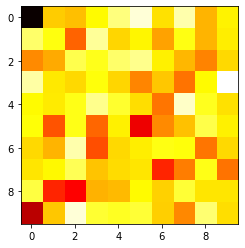

1/1 [==============================] - 0s 37ms/step
(3, 9) [3, 4]


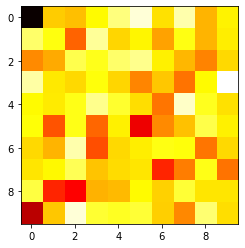

1/1 [==============================] - 0s 26ms/step
(3, 9) [8, 6]


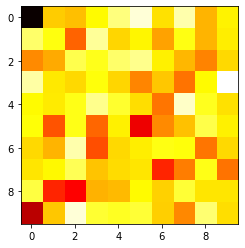

1/1 [==============================] - 0s 27ms/step
(3, 9) [7, 8]


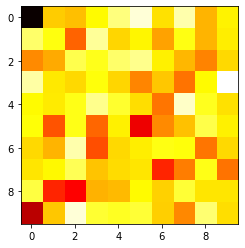

1/1 [==============================] - 0s 27ms/step
(3, 9) [5, 6]


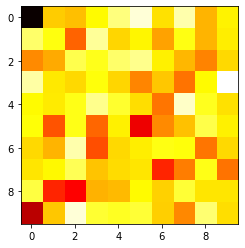

1/1 [==============================] - 0s 26ms/step
(3, 9) [9, 6]


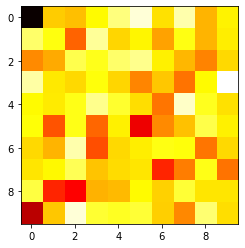

1/1 [==============================] - 0s 29ms/step
(3, 9) [1, 7]


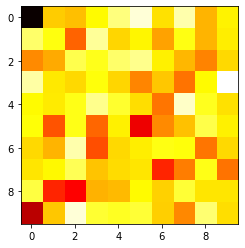

1/1 [==============================] - 0s 31ms/step
(3, 9) [8, 4]


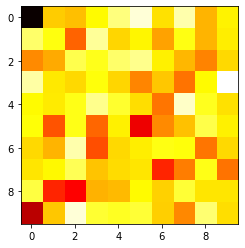

1/1 [==============================] - 0s 31ms/step
(3, 9) [0, 2]


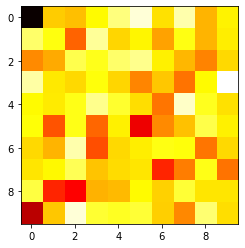

1/1 [==============================] - 0s 25ms/step
(3, 9) [4, 7]


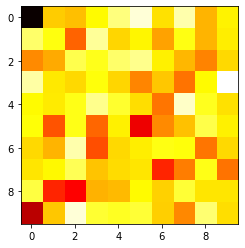

In [ ]:
for i in random.sample(range(len(train_dataset)), 10):
  pred = model.predict(np.array([f(train_dataset[i][0])]))[0].reshape(10, 10)
  print(np.unravel_index(np.argmax(pred), pred.shape), train_dataset[i][1])
  plt.figure()
  plt.imshow(pred, cmap="hot")  
  plt.show()

In [ ]:
import copy
copyObj = copy.copy(g)

In [ ]:
copyObj.__dict__

{'objects': {'.': ['.', 0],
  'a': ['b', 1],
  'b': ['c', 5],
  'c': ['d', 25],
  'd': ['e', 125],
  'e': ['e', 625],
  '1': ['1', -25],
  '2': ['3', -5],
  '3': ['4', 50],
  '4': ['4', 500],
  'x': ['x', -50]},
 'matrix': [['b', 'a', 'a', '2', 'a', '2', 'a', 'a', '3', 'a'],
  ['2', 'a', '2', 'a', '2', 'a', '2', 'a', '2', 'a'],
  ['a', '2', 'a', 'c', 'a', 'b', 'a', 'c', 'a', 'b'],
  ['a', 'c', 'a', '3', 'a', '2', 'a', '2', 'a', 'b'],
  ['b', '2', 'c', '2', '2', 'c', '3', 'a', 'c', '2'],
  ['b', 'a', '2', 'a', 'b', 'a', 'c', 'a', '2', 'a'],
  ['a', 'b', '2', 'c', 'd', '2', 'a', '3', 'a', 'a'],
  ['a', 'b', 'd', 'a', 'a', 'c', 'a', 'd', 'a', '2'],
  ['d', '3', 'b', '2', 'c', 'x', 'b', '2', 'a', 'a'],
  ['a', 'b', 'a', 'a', 'c', '2', 'a', 'a', '2', 'a']],
 'seq': '',
 'turn': 227,
 'score': [-14,
  7,
  10,
  5,
  6,
  7,
  28,
  49,
  50,
  51,
  52,
  53,
  -44,
  -3,
  -2,
  -1,
  4,
  -1,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  20,
  15,
  28,
  23,
  24,
  27,
  28,
  43,
 

Que empiece el juego:😉


,0,1,2,3,4,5
A,a,.,a,2,b,.
B,.,1,.,a,3,.
C,.,.,a,.,c,c
D,a,.,.,a,.,c
E,a,.,a,a,1,.
F,.,a,a,c,.,b



Turno: 7 Puntos:116
Almacen: [.] Actual: [a]
Mover a casilla: a1


,0,1,2,3,4,5
A,.,b,.,2,b,.
B,.,.,1,a,3,.
C,.,.,a,.,c,c
D,a,.,.,a,1,c
E,a,.,a,a,.,.
F,.,a,a,c,.,b



Turno: 8 Puntos:119
Almacen: [.] Actual: [1]
Mover a casilla: a5


,0,1,2,3,4,5
A,.,b,1,2,b,1
B,.,.,.,a,3,.
C,.,.,a,.,c,c
D,a,.,.,a,.,c
E,a,.,a,a,1,.
F,.,a,a,c,.,b



Turno: 9 Puntos:94
Almacen: [.] Actual: [a]
Mover a casilla: exit
Partida terminada, GG:👏


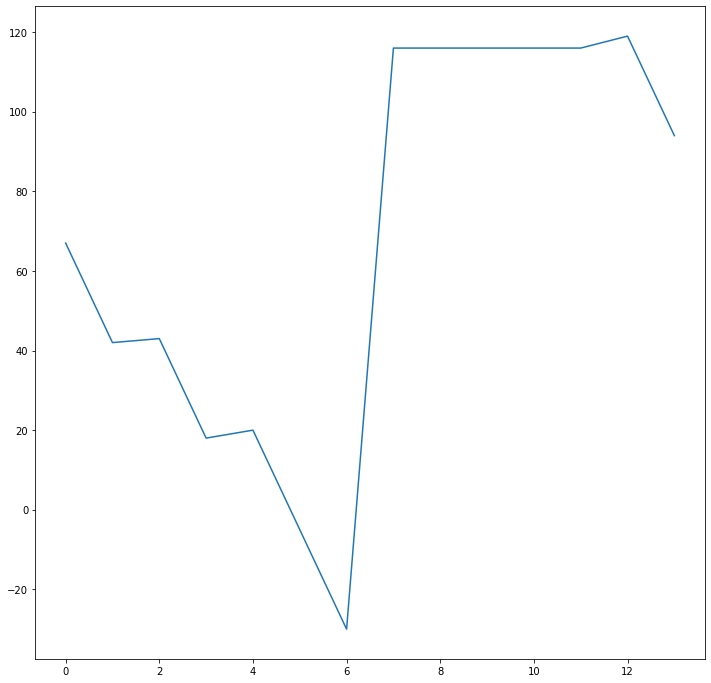

In [ ]:
copyObj.main()